# Code for "Generalization Through The Lens of Leave-One-Out Error"

In this notebook we provide code for our paper "Generalization Through The Lens of Leave-One-Out-Error". We present the mathematical results along with the corresponding implementations. We tried to make the notation in this notebook self-contained, however some details might require more technical explanations. For a more precise introduction to the theoretical parts, please check out our [paper](https://openreview.net/pdf?id=7grkzyj89A_).

## Setup

You will need to install the following packages in order to run the code:
<pre>
- numpy           1.21.5
- jax             0.2.26
- jaxlib          0.1.75
- torchvision     0.11.2
- neural_tangents 0.3.9
</pre>

First we import the neccessary functions for the leave-one-out computations.

In [2]:
import jax.numpy as jnp

from kernels import NTK
from utils import mse_loss, accuracy, get_dataset

## A First Example

We first run a basic example on *CIFAR10* with a fully-connected neural tangent kernel. We will then vary the parameter setting by changing the sample size, the kernel function and the inherent complexity in the model.

### Prepare data
We specify the parameters and load the dataset. We choose *CIFAR10* but you can also specify *MNIST* instead.

In [39]:
# Define the parameters
n_train = 5000
n_test = 10000
classes = 10          # One of 10 or 2 (i.e. binary classification)
dataset = 'CIFAR'     # One of 'CIFAR' or 'MNIST'
flat = True           # For fully-connected kernels, we flatten the inputs
download = False      # Set to true if you have not downloaded the dataset

# Prepare the data
data = get_dataset(name=dataset, n_train=n_train, n_test=n_test, classes=classes, flat=flat, download=download)

### Train model
We specify a neural tangent kernel **K** of depth 5 and then fit the model to the training data, according to the kernel equation, i.e. we calculate the pseudo-inverse of the training Gram matrix and project it down with the training labels. Using the pseudo-inverse corresponds to the minimum-norm interpolator (i.e. zero L2 regularization) which is the primary focus of this notebook. Check out our paper for more details concerning the case of L2 regularization. We can summarize the predictive function with the following formula:
<img src="./markdown_pics/kernel_fit.png" width="800" />

In [14]:
# Define the model and fit it to the training data
model = NTK(depth=5)
model.fit(data.x_train, data.y_train)

### Predict on training and test set
Next, we form predictions with the learnt function, both on training and test examples. Then we calculate the training and test statistics, i.e. both mean-squared loss and accuracy. The test loss and accuracy serve as a proxy for the true generalization loss and accuracy, defined as 
<img src="markdown_pics/generalization.png" width="800" />
which is usually intractable due to the lack of knowledge of the data distribution. We will demonstrate that the leave-one-out error is another way to obtain an accurate estimate that does **not** need access to a held-out testset.

In [15]:
# Predict on train and test set
preds_train = model.predict(data.x_train, mode='train')
preds_test = model.predict(data.x_test, mode='test')

# Calculate the train and test statistics
train_loss = mse_loss(preds_train, data.y_train)
train_acc = accuracy(preds_train, data.y_train)
test_loss = mse_loss(preds_test, data.y_test)
test_acc = accuracy(preds_test, data.y_test)


### Leave-One-Out Loss and Accuracy
We can now also calculate the leave-one-out error and accuracy efficiently, due to the short-cut formula shown in Theorem 3.2, stating that the leave-one-out loss and accuracy can be calculated as 
<img src="markdown_pics/leave_one_out.png" width="800" />

This expression concerns kernel ridge regression, where we add a L2 regularization term. Recent studies however indicate that explicit regularization does not seem to be essential to the success of deep learning. As a result we also derived an expression in the case of zero regularization (i.e. for the minimum norm interpolator), which we will use in our calculations. We display the mathematical expression that the residuals take in this regime in the following:
<img src="markdown_pics/loo_unregularized.png" width="500"/>
We see that the formula depends on the rank of the kernel matrix, which serves as a measure of complexity. Full rank (i.e. r=n) implies that the kernel is invertible, leading to zero training error. We will discuss this in more detail in the next section. Neural Tangent kernels tend to have full rank.

In [16]:
loo_loss, loo_acc = model.leave_one_out()

We can now compare the resulting statistics to understand how well the leave-one-out loss reflects the test loss as well as the corresponding accuracies:

In [17]:
print('-------------Loss-------------')
print('Train Loss:           ' + '%.4f' % train_loss)
print('Test Loss:            ' + '%.4f' % test_loss)
print('LOO Loss:             ' + '%.4f' % loo_loss)
print('-----------Accuracy-----------')
print('Train Accuracy:       ' + '%.2f' % (100 * train_acc) + ' %')
print('Test Accuracy:         ' + '%.2f' % (100 * test_acc) + ' %')
print('LOO Accuracy:          ' + '%.2f' % (100 * loo_acc) + ' %')

-------------Loss-------------
Train Loss:           0.0000
Test Loss:            0.7217
LOO Loss:             0.7251
-----------Accuracy-----------
Train Accuracy:       100.00 %
Test Accuracy:         46.96 %
LOO Accuracy:          46.42 %


We see that, as anticipated, the kernel has full rank and thus exhibits zero training loss and perfect training accuracy. On the other hand we find that the leave-one-out statistics reflect the test statistics almost perfectly. The framework of leave-one-out error hence gives us a tool to accurately predict the generalization of a model while only relying on the training data!

## Varying Sample Size 

We now vary the sample size used for training the model to study how the predictive quality of the leave-one-out error changes. We will essentially run the same script as above in a for-loop.

In [37]:
# Specify the sample size grid and the other parameters
dataset = 'CIFAR'
n_test = 10000
classes = 10
n_trains = classes * jnp.linspace(50, 600, num=10,  dtype=int)
flat = True
download = False

train_losses, test_losses, loo_losses = [], [], []
train_accs, test_accs, loo_accs = [], [], []

for i in range(n_trains.shape[0]):
    # Get dataset of size i
    n = n_trains[i]
    data = get_dataset(name=dataset, n_train=n, n_test=n_test, classes=classes, flat=flat, download=download)
    # Define and fit the model
    model = NTK(depth=5)
    model.fit(data.x_train, data.y_train)
    # Predict on test and train set
    preds_train = model.predict(data.x_train, mode='train')
    preds_test = model.predict(data.x_test, mode='test')
    # Calculate the train and test statistics
    train_losses.append(mse_loss(preds_train, data.y_train))
    train_accs.append(accuracy(preds_train, data.y_train))
    test_losses.append(mse_loss(preds_test, data.y_test))
    test_accs.append(accuracy(preds_test, data.y_test))
    # Calculate the leave-one-out statistics
    loo_loss, loo_acc = model.leave_one_out()
    loo_losses.append(loo_loss)
    loo_accs.append(loo_acc)
    print('Completed iteration', i + 1, 'out of', n_trains.shape[0])

Completed iteration 1 out of 10
Completed iteration 2 out of 10
Completed iteration 3 out of 10
Completed iteration 4 out of 10
Completed iteration 5 out of 10
Completed iteration 6 out of 10
Completed iteration 7 out of 10
Completed iteration 8 out of 10
Completed iteration 9 out of 10
Completed iteration 10 out of 10


Next we visualize the resulting statistics as a function of the sample size:

In [7]:
import matplotlib.pyplot as plt

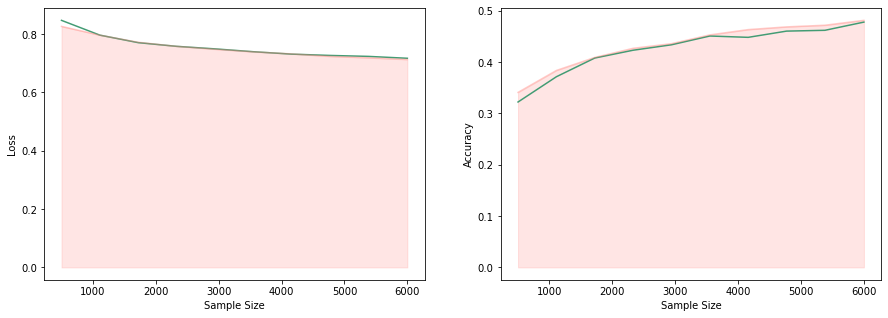

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(n_trains, loo_losses, c='#439c74')
axes[0].plot(n_trains, test_losses, c='#ff7f78', alpha=0.4)
axes[0].fill_between(n_trains, test_losses, color='#ff7f78', alpha=0.2)
axes[0].set_xlabel('Sample Size')
axes[0].set_ylabel('Loss')
axes[1].plot(n_trains, loo_accs, c='#439c74')
axes[1].plot(n_trains, test_accs, c='#ff7f78', alpha=0.4)
axes[1].fill_between(n_trains, test_accs, color='#ff7f78', alpha=0.2)
axes[1].set_xlabel('Sample Size')
axes[1].set_ylabel('Accuracy')
plt.show()

We see that the leave-one-out statistics match the test statistics almost exactly across different sample sizes. 

## Leave-One-Out Exhibits Double Descent

Finally, we study how the leave-one-out loss and accuracy varies as we adapt the complexity of the model. Since the neural tangent kernel tends to achieve zero training loss (i.e. its complexity is always beyond the interpolation point), we instead study the **random feature** model, where we can vary the inherent complexity.

In [4]:
from kernels import RF

The random features kernel is defined through the feature map 
<img src="markdown_pics/randomfeatures.png" width="500"/>
where the width 'm' increases the dimensionality of the feature map. Notice that the parameters **V** remain random. Increasing the complexity reduces the training loss as we empirically observe that for most datasets it holds that 
<img src="markdown_pics/rank.png" width="400"/>
In other words, we reach the interpolation point (i.e. zero training error) once the width 'm' exceeds the training set size 'n'.

In [23]:
# Specify the widths and the other parameters
dataset = 'MNIST'
n_train = 2000
n_test = 10000
classes = 10
widths = jnp.linspace(50, 2*n_train, num=20,  dtype=int)
flat = True
download = False

train_losses, test_losses, loo_losses = [], [], []
train_accs, test_accs, loo_accs = [], [], []

data = get_dataset(name=dataset, n_train=n_train, n_test=n_test, classes=classes, flat=flat, download=download)

for i in range(widths.shape[0]):
    # Get dataset of size i
    width = widths[i]
    
    # Define and fit the model
    model = RF(width=width)
    model.fit(data.x_train, data.y_train)
    # Predict on test and train set
    preds_train = model.predict(data.x_train, mode='train')
    preds_test = model.predict(data.x_test, mode='test')
    # Calculate the train and test statistics
    train_losses.append(mse_loss(preds_train, data.y_train))
    train_accs.append(accuracy(preds_train, data.y_train))
    test_losses.append(mse_loss(preds_test, data.y_test))
    test_accs.append(accuracy(preds_test, data.y_test))
    # Calculate the leave-one-out statistics
    loo_loss, loo_acc = model.leave_one_out()
    loo_losses.append(loo_loss)
    loo_accs.append(loo_acc)
    print('Completed iteration', i + 1, 'out of', widths.shape[0])

Completed iteration 1 out of 20
Completed iteration 2 out of 20
Completed iteration 3 out of 20
Completed iteration 4 out of 20
Completed iteration 5 out of 20
Completed iteration 6 out of 20
Completed iteration 7 out of 20
Completed iteration 8 out of 20
Completed iteration 9 out of 20
Completed iteration 10 out of 20
Completed iteration 11 out of 20
Completed iteration 12 out of 20
Completed iteration 13 out of 20
Completed iteration 14 out of 20
Completed iteration 15 out of 20
Completed iteration 16 out of 20
Completed iteration 17 out of 20
Completed iteration 18 out of 20
Completed iteration 19 out of 20
Completed iteration 20 out of 20


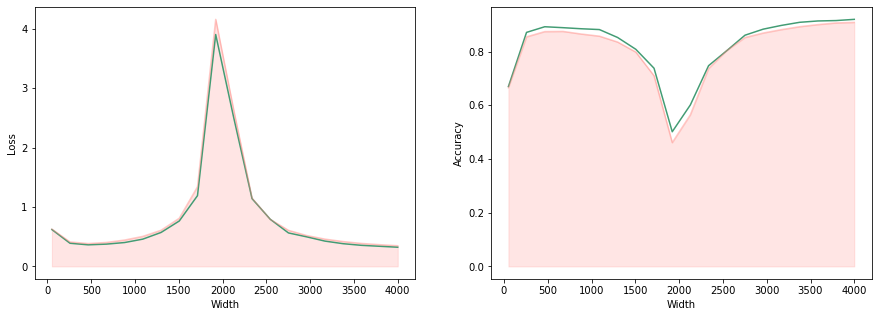

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(widths, loo_losses, c='#439c74')
axes[0].plot(widths, test_losses, c='#ff7f78', alpha=0.4)
axes[0].fill_between(widths, test_losses, color='#ff7f78', alpha=0.2)
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Loss')
axes[1].plot(widths, loo_accs, c='#439c74')
axes[1].plot(widths, test_accs, c='#ff7f78', alpha=0.4)
axes[1].fill_between(widths, test_accs, color='#ff7f78', alpha=0.2)
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Accuracy')
plt.show()

We find a very good agreement again between test and leave-one-out statistics across varying complexity settings. Moreover, the leave-one-out error exhibits the famous double-descent curve, as predicted by Theorem 4.3.